# Monte Carlo Simulation and Hedging for European Options

This notebook explores the pricing and hedging of European options using Monte Carlo simulation techniques. It covers:

- Implementation of the Black-Scholes formula for option pricing and Greeks.
- Monte Carlo methods for pricing European call and put options, including both closed-form and Euler discretization schemes.
- Analysis of estimator convergence, confidence intervals, and bias/variance trade-offs.
- Simulation of digital options and comparison with analytical results.
- Hedging strategies using discrete rebalancing, examining the impact of rebalancing frequency and drift on hedging error.
- Investigation of hedging performance when implied and realized volatilities differ.

The notebook includes code, visualizations, and detailed explanations to illustrate the concepts and results.

In [300]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
from scipy.stats import norm

## Problem 1

a. Yes the Confidence interval contains the true price
<br>
b. Yes the Confidence interval contains the true price
<br>
d. The two sources of error are bias and variance. The way to reduce the error in variance is by increasing the number of simulations. In order to reduce the error in bias we increase the number of steps, m or decrease the time step dt.
<br>
e. We look at the different distributions of stock prices at time T = 1 for a, b and the event where m = 1. When m = 1 we have a normal distribution. For m = 5 it is the product of normal random variables which is not normal and approximates the tail much better than for m = 1. It does not have as much density at the peak as the log normally distributed version that we got from simulating based on geometric brownian motion, but it was close.

<br>
<br>
Extra Credit
<br>
a. Like in part e we see that the lack of the fat tail on the upside and lack of skew makes this have bias when calculating the stock price and the value of the option.
<br>
b. With a greater strike price we also get bias and the interval does not include the true price of the option because the tails are not fat enough when simulating to get enough values over 130 to get an accurate price for a strike of 130.
<br>
c. With a digital option we have a higher value since the size of the tails does not matter unlike a call option. The discontinuity around the strike also makes the bias show.



In [301]:
def black_scholes(S_0, sigma, r, T, K, option_type='call'):
    d1 = (np.log(S_0 / K) + (r + (sigma ** 2) / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    gamma = norm.pdf(d1)/(S_0*sigma*np.sqrt(T))

    if option_type == 'call':
        option_price = S_0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        delta = norm.cdf(d1)
    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S_0 * norm.cdf(-d1)
        delta = norm.cdf(d1) - 1
    else:
        raise ValueError("Option type must be 'call' or 'put'.")

    return option_price, d1,d2, delta, gamma


In [302]:
def monte_carlo_euro_option(S_0, sigma, r, T, K, n, option_type = 'call'):
    S_Ts = []
    V_Ts = []
    for i in range(n):
        z = np.random.standard_normal()
        W_T = np.sqrt(T)*z
        S_T = S_0*np.exp((r-(sigma**2)/2)*T + sigma*W_T)
        if option_type == 'call':
            V_T = max(S_T - K, 0)
        else:
            V_T = max(K-S_T, 0)
        S_Ts.append(S_T)
        V_Ts.append(V_T)
    V_0s = np.exp(-r*T)*np.array(V_Ts)
    option_price = np.mean(V_0s)
    sample_var = np.var(V_0s, ddof = 1)
    CI = [option_price - 1.96*np.sqrt(sample_var/n),option_price + 1.96*np.sqrt(sample_var/n)]
    return option_price, CI


In [303]:
#Much quicker than the above method if doing 10 million or more simulations
def monte_carlo_euro_option_vectorization(S_0, sigma, r, T, K, n, option_type = 'call'):
    zs = np.random.standard_normal(n)
    W_Ts = np.sqrt(T)*zs
    S_Ts = S_0*np.exp((r-(sigma**2)/2)*T + sigma*W_Ts)
    zeros = np.zeros(n)
    if option_type == 'call':
        V_Ts = np.maximum(zeros, S_Ts-K)
    else:
        V_Ts = np.maximum(zeros, K-S_Ts)
    V_0s = np.exp(-r*T)*np.array(V_Ts)
    option_price = np.mean(V_0s)
    sample_var = np.var(V_0s, ddof = 1)
    CI = [option_price - 1.96*np.sqrt(sample_var/n),option_price + 1.96*np.sqrt(sample_var/n)]
    return option_price, CI, V_0s, S_Ts
        

In [304]:
S_0 = 100
sigma = .3
r= .05
T = 1
K = 100
n = 100000
option_type = 'call'
a = monte_carlo_euro_option_vectorization(S_0, sigma, r, T, K, n, option_type = 'call')
print('The closed form gbm gives a value of: '+str(a[0])+ ' with a 95% CI of: '+str(a[1]))

The closed form gbm gives a value of: 14.163810072452472 with a 95% CI of: [14.025456550080472, 14.302163594824473]


In [305]:
bs = black_scholes(S_0, sigma, r, T, K, option_type='call')
print('The true price of the option is: '+ str(bs[0])) 

The true price of the option is: 14.231254785985819


In [306]:
def monte_carlo_euro_option_biased(S_0, sigma, r, T, K, n, m, option_type = 'call'):
    dt = T/m
    zs = np.random.standard_normal((n, m))
    S = S_0 
    S_Ts = []
    for i in range(m):
        S_T = S*np.ones(n) + .05*S*dt + .3*S*np.sqrt(dt)*zs[:,i]
        S = S_T
        S_Ts.append(S) 
    
    S_Ts = np.array(list(map(list, zip(*S_Ts))))
    zeros = np.zeros(n)
    if option_type == 'call':
        V_Ts = np.maximum(S_Ts[:,-1]-K,zeros)
    else:
        V_Ts = np.maximum(K-S_Ts[:,-1],zeros)
    V_0s = V_Ts*np.exp(-r*T)
    option_price = np.mean(V_0s)    
    sample_var = np.var(V_0s, ddof = 1)
    CI = [option_price - 1.96*np.sqrt(sample_var/n),option_price + 1.96*np.sqrt(sample_var/n)]
    
    return option_price, CI, V_0s, S_Ts[:,-1]
        

In [307]:
m = 5
b = monte_carlo_euro_option_biased(S_0, sigma, r, T, K, n, m, option_type = 'call')
print('The Euler discretization scheme gives: '+str(b[0])+ ' with a 95% CI of: '+str(b[1]))

The Euler discretization scheme gives: 14.157768067597502 with a 95% CI of: [14.024333837201413, 14.29120229799359]


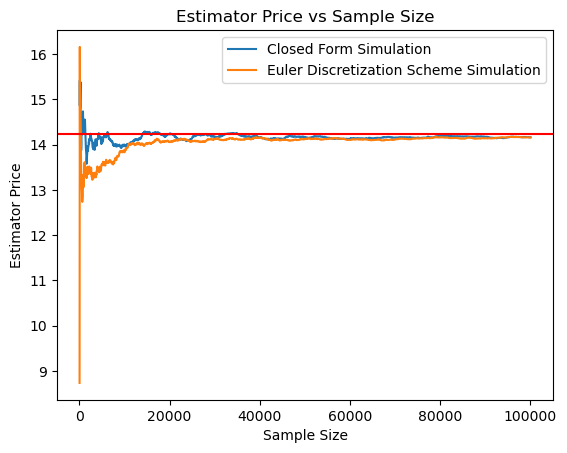

In [308]:
ks = np.arange(50, 100050, 50)
closed = []
euler = []
for k in ks:
    closed.append(np.mean(a[2][:k]))
    euler.append(np.mean(b[2][:k]))

fig, ((ax1)) = plt.subplots(1)
ax1.plot(ks, closed, label = 'Closed Form Simulation')
ax1.plot(ks, euler, label = 'Euler Discretization Scheme Simulation')
ax1.axhline(y = bs[0], color = 'r')
ax1.set_title('Estimator Price vs Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Estimator Price')
plt.legend()
plt.show()

In [309]:
n = 100000
m = 1
K = 100
ec_a =  monte_carlo_euro_option_biased(S_0, sigma, r, T, K, n, m, option_type = 'call')
ec_a

(13.944091847622108,
 [13.830849948175427, 14.057333747068789],
 array([24.82781642,  0.        ,  0.        , ..., 63.35480211,
        37.07483822, 22.33310459]),
 array([126.10076579,  77.98953665,  97.79709585, ..., 166.60307228,
        138.97570582, 123.47814735]))

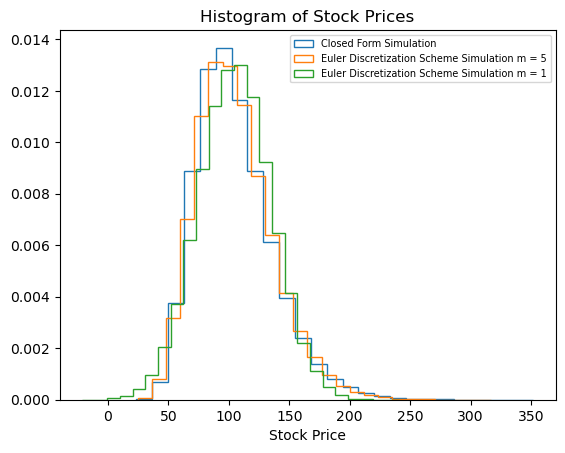

In [310]:
fig, ((ax1)) = plt.subplots(1)
ax1.hist(a[3], bins = 25, density = True, histtype = 'step', label = 'Closed Form Simulation')
ax1.hist(b[3], bins = 25, density = True, histtype = 'step', label = 'Euler Discretization Scheme Simulation m = 5')
ax1.hist(ec_a[3], bins = 25, density = True, histtype = 'step', label = 'Euler Discretization Scheme Simulation m = 1')

ax1.set_title('Histogram of Stock Prices')
plt.xlabel('Stock Price')
plt.legend(fontsize = '7')
plt.show()

In [311]:
m = 5
K = 130
ec_b1 = monte_carlo_euro_option_vectorization(S_0, sigma, r, T, K, n, option_type = 'call')
ec_b2 =  monte_carlo_euro_option_biased(S_0, sigma, r, T, K, n, m, option_type = 'call')
black_scholes(S_0, sigma, r, T, K, option_type='call')[0]

4.673372434409671

In [312]:
ec_b1[0:2]

(4.718267990928163, [4.631851375714075, 4.80468460614225])

In [313]:
ec_b2[0:2]

(4.4336703885380455, [4.354826675418243, 4.512514101657848])

In [314]:
def monte_carlo_digital_option_vectorization(S_0, sigma, r, T, K, n, option_type = 'call'):
    zs = np.random.standard_normal(n)
    W_Ts = np.sqrt(T)*zs
    S_Ts = S_0*np.exp((r-(sigma**2)/2)*T + sigma*W_Ts)
    zeros = np.zeros(n)
    if option_type == 'call':
        V_Ts = 1*(S_Ts > K)
    else:
        V_Ts = 1*(S_Ts < K)
    V_0s = np.exp(-r*T)*np.array(V_Ts)
    option_price = np.mean(V_0s)
    sample_var = np.var(V_0s, ddof = 1)
    CI = [option_price - 1.96*np.sqrt(sample_var/n),option_price + 1.96*np.sqrt(sample_var/n)]
    return option_price, CI, V_0s, S_Ts
       
def monte_carlo_digital_option_biased(S_0, sigma, r, T, K, n, m, option_type = 'call'):
    dt = T/m
    zs = np.random.standard_normal((n, m))
    S = S_0 
    S_Ts = []
    for i in range(m):
        S_T = S*np.ones(n) + .05*S*dt + .3*S*np.sqrt(dt)*zs[:,i]
        S = S_T
        S_Ts.append(S) 
    
    S_Ts = np.array(list(map(list, zip(*S_Ts))))
    zeros = np.zeros(n)
    if option_type == 'call':
        V_Ts = 1*(S_Ts[:,-1]>K)
    else:
        V_Ts = 1*(K>S_Ts[:,-1])
    V_0s = V_Ts*np.exp(-r*T)
    option_price = np.mean(V_0s)    
    sample_var = np.var(V_0s, ddof = 1)
    CI = [option_price - 1.96*np.sqrt(sample_var/n),option_price + 1.96*np.sqrt(sample_var/n)]
    
    return option_price, CI, V_0s, S_Ts[:,-1]
 

In [315]:
S_0 = 100
sigma = .3
r= .05
T = 1
K = 100
n = 100000
monte_carlo_digital_option_vectorization(S_0, sigma, r, T, K, n, option_type = 'call')[0:2]

(0.4812459904434012, [0.4782982918103968, 0.48419368907640564])

In [316]:
monte_carlo_digital_option_biased(S_0, sigma, r, T, K, n, m, option_type = 'call')[0:2]

(0.49173805099564416, [0.48879184009650556, 0.49468426189478276])

## Problem 2

a. We see from the histogram that daily rebalancing has a PnL distribution that is much tighter than the weekly rebalancing. The standard deviation is smaller and the average loss is closer to zero as well.
<br>
b. As mu increases, the mean hedging error increasingly deviates from zero. The weekly rebalancing deviates at a rate much higher than the daily rebalancing. It also has a higher std deviation which we saw in the histogram. This can be because the larger drift raises the price of the stock more than the value of the option. This acts as undervaluing the option thus we lose money when hedging because we are short the option and do not get enough premium in return.
<br>
c. From the log-log plot we see the rate of convergence is about 2/4 = 1/2

In [317]:
def monte_carlo_hedging(S_0, sigma, r, T, K, n, m, mu, option_type = 'call'):
    dt = T/m
    zs = np.random.standard_normal((n, m))
    
    S = S_0
    current_T_left = T
    
    initial_option_value = black_scholes(S_0, sigma, r, T, K, option_type)[0]
    initial_port_shares = black_scholes(S_0, sigma, r, T, K, option_type)[3]
    initial_port_value = initial_option_value-initial_port_shares*S_0
    
    port_value = np.ones(n)*initial_port_value
    
    stock_paths = []
    bs_prices = []
    port_shares = []
    port_values = []
    pnl_vectors = []
    rebalance_cashes = []
    
    for i in range(m):
        
        current_T_left = current_T_left - dt
        S_T = S*np.exp((mu-(sigma**2)/2)*dt + sigma*np.sqrt(dt)*zs[:,i])
        S = S_T
        stock_paths.append(S_T)
        
        bs_price = black_scholes(S, sigma, r, current_T_left, K, option_type)[0]
        bs_prices.append(bs_price)
        bs_delta = black_scholes(S, sigma, r, current_T_left, K, option_type)[3]
        port_shares.append(bs_delta)
        
        if i == 0:
            rebalance_cash = (np.ones(n)*initial_port_shares - port_shares[i])*S
        
        elif i == m-1:
            zeros = np.zeros(n)
            
            if option_type == 'call':
                rebalance_cash = port_shares[i-1]*S - np.maximum(zeros, S- K)
            else: 
                rebalance_cash = port_shares[i-1]*S - np.maximum(zeros, K- S)
        else:
            rebalance_cash = (port_shares[i-1] - port_shares[i])*S
        rebalance_cashes.append(rebalance_cash)
        port_value = port_value*np.exp(r*dt) + rebalance_cash
        port_values.append(np.array(port_value))
    
    
    
        
    stock_paths  = list(map(list, zip(*stock_paths)))
    bs_prices, port_shares =list(map(list, zip(*bs_prices))), list(map(list, zip(*port_shares)))
    rebalance_cashes, port_values = list(map(list , zip(*rebalance_cashes))), list(map(list , zip(*port_values)))
    
    port_values = np.array(port_values)
    pnl_vector = port_values[:, -1]
    sample_mean = np.mean(pnl_vector)
    sample_var = np.var(pnl_vector, ddof = 1)
    sample_std = np.sqrt(sample_var)
    

    
    return port_values, pnl_vector, sample_mean, sample_std 
        

In [318]:
S_0 = 50
sigma = .3
K = 50
mu = .1
r = .05
T= .25
n= 10000
m = 13
x_13 = monte_carlo_hedging(S_0, sigma, r, T, K, n, m, mu, option_type = 'call')
m = 63
x_63 = monte_carlo_hedging(S_0, sigma, r, T, K, n, m, mu, option_type = 'call')

In [319]:
x_13

(array([[-31.69530089, -35.98917781, -34.55872032, ..., -49.51829312,
         -49.81129286,   0.14066793],
        [-24.19136712, -18.77119882, -15.47392297, ..., -12.20990147,
          -1.43438605,   0.76727073],
        [-26.26469859, -21.92574818, -23.19278125, ..., -37.64715089,
         -24.02254884,   0.58720698],
        ...,
        [-29.45101439, -25.64519647, -37.96244141, ..., -45.06363662,
         -25.16382336,  -0.44539171],
        [-30.9637138 , -35.89384819, -36.4936454 , ..., -16.92871887,
         -18.65387482,   0.5823468 ],
        [-39.07420011, -45.21385553, -47.87515374, ..., -50.61597416,
         -50.66483073,  -0.71357035]]),
 array([ 0.14066793,  0.76727073,  0.58720698, ..., -0.44539171,
         0.5823468 , -0.71357035]),
 0.01262037027151254,
 0.6894786482186168)

In [320]:
x_63

(array([[-2.30022218e+01, -2.11867448e+01, -1.96264505e+01, ...,
         -2.65678520e+00, -4.56290625e-01, -4.55081039e-01],
        [-2.33642789e+01, -1.92936119e+01, -1.82235814e+01, ...,
         -4.55349561e+01, -4.52503840e+01,  5.50924684e-01],
        [-2.17964986e+01, -2.48345314e+01, -2.66957587e+01, ...,
         -5.03537805e+01, -5.03637802e+01, -3.73774096e-01],
        ...,
        [-2.47541738e+01, -2.48672173e+01, -2.60687479e+01, ...,
         -4.89028707e+01, -4.85248481e+01,  3.59835666e-01],
        [-2.66929550e+01, -2.22548882e+01, -2.20829901e+01, ...,
          8.51314901e-03,  1.17622065e-01,  1.19266490e-01],
        [-2.50154750e+01, -2.45249451e+01, -1.92817622e+01, ...,
         -4.98539599e+01, -4.98638526e+01,  1.26252818e-01]]),
 array([-0.45508104,  0.55092468, -0.3737741 , ...,  0.35983567,
         0.11926649,  0.12625282]),
 0.005236327584735776,
 0.3229628355492369)

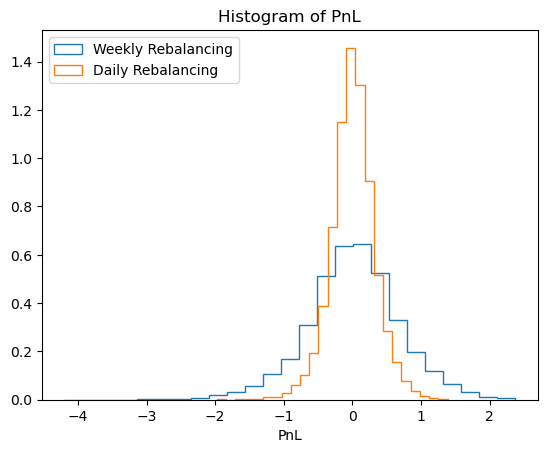

In [321]:
fig, ((ax1)) = plt.subplots(1)
ax1.hist(x_13[1], bins = 25, density = True, histtype = 'step', label = 'Weekly Rebalancing')
ax1.hist(x_63[1], bins = 25, density = True, histtype = 'step', label = 'Daily Rebalancing')

ax1.set_title('Histogram of PnL')
plt.xlabel('PnL')
plt.legend()
plt.show()

In [322]:
mus = np.arange(r, 1, .01)
means_13 = []
stds_13 = []
means_63 = []
stds_63 = []
for mu in mus:
    m = 13
    res_13 = monte_carlo_hedging(S_0, sigma, r, T, K, n, m, mu, option_type = 'call')
    means_13.append(res_13[2])
    stds_13.append(res_13[3])
    m = 63
    res_63 = monte_carlo_hedging(S_0, sigma, r, T, K, n, m, mu, option_type = 'call')
    means_63.append(res_63[2])
    stds_63.append(res_63[3])

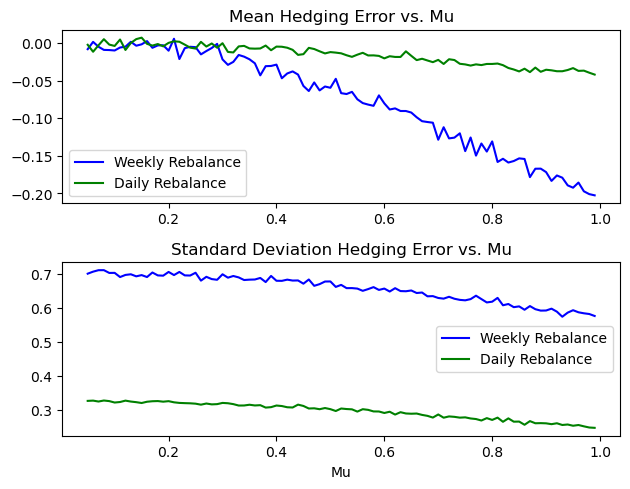

In [323]:
fig, ((ax1, ax2)) = plt.subplots(2)
ax1.plot(mus, means_13,color='blue', label = 'Weekly Rebalance')
ax1.plot(mus, means_63,color='green', label ='Daily Rebalance')
ax1.set_title("Mean Hedging Error vs. Mu")


ax2.plot(mus, stds_13,color='blue', label = 'Weekly Rebalance')
ax2.plot(mus, stds_63,color='green', label ='Daily Rebalance')
ax2.set_title("Standard Deviation Hedging Error vs. Mu")

fig.tight_layout()
ax1.legend()
ax2.legend()
plt.xlabel('Mu')
plt.show()

In [324]:
S_0 = 50
sigma = .3
K = 50
mu = .1
r = .05
T= .25
n= 10000
m = 13
x_13 = monte_carlo_hedging(S_0, sigma, r, T, K, n, m, mu, option_type = 'call')
m = 63
x_63 = monte_carlo_hedging(S_0, sigma, r, T, K, n, m, mu, option_type = 'call')
m = 252
x_252 = monte_carlo_hedging(S_0, sigma, r, T, K, n, m, mu, option_type = 'call')
m = 1008
x_1008 = monte_carlo_hedging(S_0, sigma, r, T, K, n, m, mu, option_type = 'call')


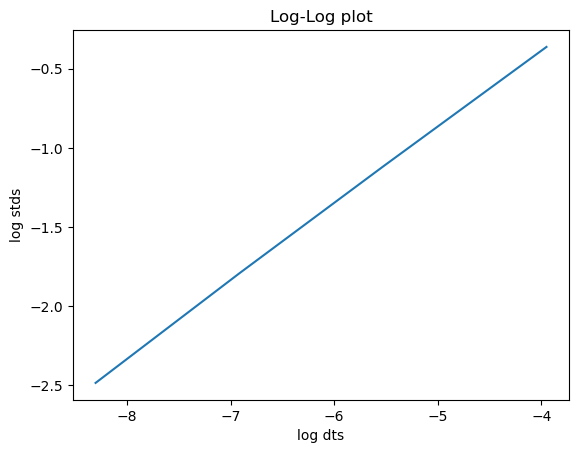

In [325]:
log_dts= [np.log(T/13),np.log(T/63),np.log(T/252),np.log(T/1008)]
log_stds = [np.log(x_13[3]),np.log(x_63[3]),np.log(x_252[3]),np.log(x_1008[3])]
fig, ((ax1)) = plt.subplots(1)
ax1.plot(log_dts, log_stds)
ax1.set_title('Log-Log plot')
plt.xlabel('log dts')
plt.ylabel('log stds')
plt.show()

## Problem 3
a. We see the histogram of this behave similarly to the histogram in 2a. The daily rebalancing has a smaller std deviation and is much tighter. 
<br>
b. We see that we make profit this time as the histogram is shifted with mean around 1. The more frequently we rebalance the more likely we are to end up at the mean.
<br>
c. You can make profit by going short the call option. This is because the option is over priced initially so you receive more initial investment than you should thus when you hedge you come out with profit. 

In [326]:
def monte_carlo_hedging_diff_sigmas(S_0, implied_sigma, realized_sigma, r, T, K, n, m, option_type = 'call'):
    dt = T/m
    zs = np.random.standard_normal((n, m))
    
    S = S_0
    current_T_left = T
    
    initial_option_value = black_scholes(S_0, implied_sigma, r, T, K, option_type)[0]
    initial_port_shares = black_scholes(S_0, implied_sigma, r, T, K, option_type)[3]
    initial_port_value = initial_option_value-initial_port_shares*S_0
    
    port_value = np.ones(n)*initial_port_value
    
    stock_paths = []
    bs_prices = []
    port_shares = []
    port_values = []
    pnl_vectors = []
    rebalance_cashes = []
    
    for i in range(m):
        
        current_T_left = current_T_left - dt
        S_T = S*np.exp((r-(realized_sigma**2)/2)*dt + realized_sigma*np.sqrt(dt)*zs[:,i])
        S = S_T
        stock_paths.append(S_T)
        
        bs_price = black_scholes(S, implied_sigma, r, current_T_left, K, option_type)[0]
        bs_prices.append(bs_price)
        bs_delta = black_scholes(S, implied_sigma, r, current_T_left, K, option_type)[3]
        port_shares.append(bs_delta)
        
        if i == 0:
            rebalance_cash = (np.ones(n)*initial_port_shares - port_shares[i])*S
        
        elif i == m-1:
            zeros = np.zeros(n)
            
            if option_type == 'call':
                rebalance_cash = port_shares[i-1]*S - np.maximum(zeros, S- K)
            else: 
                rebalance_cash = (port_shares[i-1] - port_shares[i])*S - np.maximum(zeros, K- S)
        else:
            rebalance_cash = (port_shares[i-1] - port_shares[i])*S
        rebalance_cashes.append(rebalance_cash)
        port_value = port_value*np.exp(r*dt) + rebalance_cash
        port_values.append(np.array(port_value))
    
    
    stock_paths  = list(map(list, zip(*stock_paths)))
    bs_prices, port_shares =list(map(list, zip(*bs_prices))), list(map(list, zip(*port_shares)))
    rebalance_cashes, port_values = list(map(list , zip(*rebalance_cashes))), list(map(list , zip(*port_values)))
    
    port_values = np.array(port_values)
    pnl_vector = port_values[:, -1]
    sample_mean = np.mean(pnl_vector)
    sample_var = np.var(pnl_vector, ddof = 1)
    sample_std = np.sqrt(sample_var)
    

    
    return port_values, pnl_vector, sample_mean, sample_std 
        

In [327]:
S_0 = 50
implied_sigma = .3
realized_sigma = .2
K = 50
mu = .1
r = .05
T= .25
n = 10000
m = 13
x_13 = monte_carlo_hedging_diff_sigmas(S_0, implied_sigma, realized_sigma, r, T, K, n, m, option_type = 'call')
m = 63
x_63 = monte_carlo_hedging_diff_sigmas(S_0, implied_sigma, realized_sigma, r, T, K, n, m, option_type = 'call')

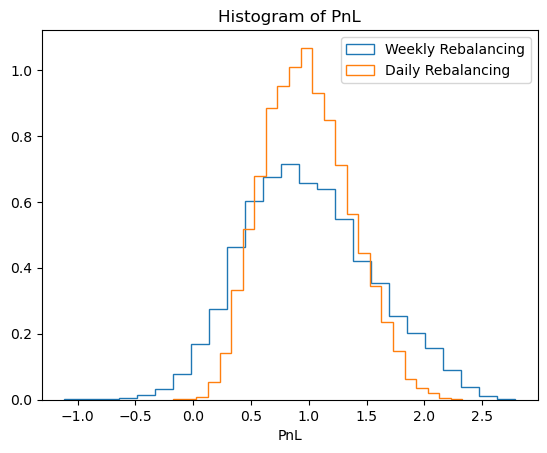

In [328]:
fig, ((ax1)) = plt.subplots(1)
ax1.hist(x_13[1], bins = 25, density = True, histtype = 'step', label = 'Weekly Rebalancing')
ax1.hist(x_63[1], bins = 25, density = True, histtype = 'step', label = 'Daily Rebalancing')

ax1.set_title('Histogram of PnL')
plt.xlabel('PnL')
plt.legend()
plt.show()

In [329]:
x_13

(array([[-22.67468476, -18.76841729, -19.31469404, ..., -39.49506529,
         -46.28002811,   0.45709702],
        [-20.01730286, -24.80204512, -25.83171005, ...,  -0.8624732 ,
           0.39482275,   0.40205175],
        [-20.22922305, -24.01924022, -26.63196102, ..., -43.46225064,
         -44.51572721,   1.29058573],
        ...,
        [-21.02523617, -20.32041756, -21.60703108, ..., -46.52547315,
         -47.63746435,   0.93928802],
        [-32.1417693 , -34.04502119, -31.06073366, ..., -33.41556728,
         -39.9140572 ,   1.26681436],
        [-25.72559346, -23.97840736, -28.11541799, ..., -17.35144013,
         -27.1617564 ,   1.47855204]]),
 array([0.45709702, 0.40205175, 1.29058573, ..., 0.93928802, 1.26681436,
        1.47855204]),
 0.9927030601153513,
 0.5543773636891103)

In [330]:
x_63

(array([[-22.09638966, -20.11153282, -19.90658692, ..., -48.92854019,
         -48.94341675,   1.04681798],
        [-26.48106157, -26.20254511, -27.52046514, ..., -49.42742928,
         -49.43733226,   0.55285735],
        [-25.38014417, -24.85531442, -24.55626444, ...,   0.64633384,
           0.6474942 ,   0.64762372],
        ...,
        [-28.03744978, -28.4568653 , -28.18854542, ..., -49.57083039,
         -49.58066685,   0.40949474],
        [-26.87349786, -26.11752689, -26.38950477, ..., -49.2001027 ,
         -49.20986564,   0.78036953],
        [-25.76261451, -26.01228008, -23.73484449, ..., -49.21820759,
         -49.26175166,   0.72483388]]),
 array([1.04681798, 0.55285735, 0.64762372, ..., 0.40949474, 0.78036953,
        0.72483388]),
 0.9881685537860742,
 0.3685417022328189)